In [1]:
import numpy as np
import cv2
import tqdm
from scipy.signal import butter
import matplotlib.pyplot as plt
from scipy.signal import find_peaks


# Constants


In [2]:
gaussian_kernel = (
    np.array(
        [
            [1, 4,  6,  4,  1],
            [4, 16, 24, 16, 4],
            [6, 24, 36, 24, 6],
            [4, 16, 24, 16, 4],
            [1, 4,  6,  4,  1]

        ]
    )
    / 256
)

yiq_from_rgb = (
    np.array(
        [
            [0.29900000,  0.58700000,  0.11400000],
            [0.59590059, -0.27455667, -0.32134392],
            [0.21153661, -0.52273617,  0.31119955]
        ]

    )
).astype(np.float32)

rgb_from_yiq = np.linalg.inv(yiq_from_rgb)

# Parameters

In [3]:
level = 4
alpha = 100
low_omega = 0.3
high_omega = 3
attenuation = 1
freq_range = [low_omega, high_omega]
kernel = gaussian_kernel

# Helper Methods


In [4]:
def loadVideo(video_path):
    image_sequence = []
    video = cv2.VideoCapture(video_path)
    fps = video.get(cv2.CAP_PROP_FPS)

    while video.isOpened():
        ret, frame = video.read()

        if ret is False:
            break

        image_sequence.append(frame[:, :, ::-1])

        if cv2.waitKey(1) == ord('q'):
            break
    video.release()

    return np.asarray(image_sequence), fps


def saveVideo(video, saving_path, fps):
    (height, width) = video[0].shape[:2]

    fourcc = cv2.VideoWriter_fourcc(*'MJPG')
    writer = cv2.VideoWriter(saving_path, fourcc, fps, (width, height))

    for i in tqdm.tqdm(range(len(video)), ascii=True, desc="Saving Video"):
        writer.write(video[i][:, :, ::-1])

    writer.release()


def rgb2yiq(rgb_image):
    image = rgb_image.astype(np.float32)
    return image @ yiq_from_rgb.T


def yiq2rgb(yiq_image):
    image = yiq_image.astype(np.float32)
    return image @ rgb_from_yiq.T


def pyrDown(image, kernel):
    return cv2.filter2D(image, -1, kernel)[::2, ::2]


def pyrUp(image, kernel, dst_shape=None):
    dst_height = image.shape[0] + 1
    dst_width = image.shape[1] + 1

    if dst_shape is not None:
        dst_height -= (dst_shape[0] % image.shape[0] != 0)
        dst_width -= (dst_shape[1] % image.shape[1] != 0)

    height_indexes = np.arange(1, dst_height)
    width_indexes = np.arange(1, dst_width)

    upsampled_image = np.insert(image, height_indexes, 0, axis=0)
    upsampled_image = np.insert(upsampled_image, width_indexes, 0, axis=1)

    return cv2.filter2D(upsampled_image, -1, 4 * kernel)


def idealTemporalBandpassFilter(images,
                                fps,
                                freq_range,
                                axis=0):

    fft = np.fft.fft(images, axis=axis)
    frequencies = np.fft.fftfreq(images.shape[0], d=1.0/fps)

    low = (np.abs(frequencies - freq_range[0])).argmin()
    high = (np.abs(frequencies - freq_range[1])).argmin()

    fft[:low] = 0
    fft[high:] = 0

    return np.fft.ifft(fft, axis=0).real

# Constants


In [5]:
gaussian_kernel = (
    np.array(
        [
            [1, 4,  6,  4,  1],
            [4, 16, 24, 16, 4],
            [6, 24, 36, 24, 6],
            [4, 16, 24, 16, 4],
            [1, 4,  6,  4,  1]

        ]
    )
    / 256
)

yiq_from_rgb = (
    np.array(
        [
            [0.29900000,  0.58700000,  0.11400000],
            [0.59590059, -0.27455667, -0.32134392],
            [0.21153661, -0.52273617,  0.31119955]
        ]

    )
).astype(np.float32)

rgb_from_yiq = np.linalg.inv(yiq_from_rgb)

# Parameters
level = 4
alpha = 100
low_omega = 0.833
high_omega = 1
attenuation = 1
freq_range = [low_omega, high_omega]
kernel = gaussian_kernel

# Helper Methods


In [6]:
def rgb2yiq(rgb_image):
    image = rgb_image.astype(np.float32)
    return image @ yiq_from_rgb.T


def yiq2rgb(yiq_image):
    image = yiq_image.astype(np.float32)
    return image @ rgb_from_yiq.T


def pyrDown(image, kernel):
    return cv2.filter2D(image, -1, kernel)[::2, ::2]


def pyrUp(image, kernel, dst_shape=None):
    dst_height = image.shape[0] + 1
    dst_width = image.shape[1] + 1

    if dst_shape is not None:
        dst_height -= (dst_shape[0] % image.shape[0] != 0)
        dst_width -= (dst_shape[1] % image.shape[1] != 0)

    height_indexes = np.arange(1, dst_height)
    width_indexes = np.arange(1, dst_width)

    upsampled_image = np.insert(image, height_indexes, 0, axis=0)
    upsampled_image = np.insert(upsampled_image, width_indexes, 0, axis=1)

    return cv2.filter2D(upsampled_image, -1, 4 * kernel)


def idealTemporalBandpassFilter(images,
                                fps,
                                freq_range,
                                axis=0):

    fft = np.fft.fft(images, axis=axis)
    frequencies = np.fft.fftfreq(images.shape[0], d=1.0/fps)

    low = (np.abs(frequencies - freq_range[0])).argmin()
    high = (np.abs(frequencies - freq_range[1])).argmin()

    fft[:low] = 0
    fft[high:] = 0

    return np.fft.ifft(fft, axis=0).real

# Gaussian Methods

In [7]:
def generateGaussianPyramid(image, kernel, level):
    image_shape = [image.shape[:2]]
    downsampled_image = image.copy()

    for _ in range(level):
        downsampled_image = pyrDown(image=downsampled_image, kernel=kernel)
        image_shape.append(downsampled_image.shape[:2])

    gaussian_pyramid = downsampled_image
    for curr_level in range(level):
        gaussian_pyramid = pyrUp(
            image=gaussian_pyramid,
            kernel=kernel,
            dst_shape=image_shape[level - curr_level - 1]
        )

    return gaussian_pyramid

In [8]:
def filterGaussianPyramids(pyramids,
                           fps,
                           freq_range,
                           alpha,
                           attenuation):

    filtered_pyramids = idealTemporalBandpassFilter(
        images=pyramids,
        fps=fps,
        freq_range=freq_range
    ).astype(np.float32)

    filtered_pyramids *= alpha
    filtered_pyramids[:, :, :, 1:] *= attenuation

    return filtered_pyramids

# Main

Loading Image, and putting it in an array

In [9]:
image_sequence = []
video = cv2.VideoCapture('face.mp4')
fps = video.get(cv2.CAP_PROP_FPS)
frame_count  = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
while video.isOpened():
    ret, frame = video.read()
    if ret is False:
        break
    image_sequence.append(frame[:,:,::-1])
images = np.asarray(image_sequence)
print(images)

[[[[242 236 243]
   [242 236 243]
   [242 236 243]
   ...
   [229 216 226]
   [229 216 226]
   [229 216 226]]

  [[242 236 243]
   [242 236 243]
   [242 236 243]
   ...
   [229 216 226]
   [229 216 226]
   [229 216 226]]

  [[242 236 243]
   [242 236 243]
   [242 236 243]
   ...
   [229 216 226]
   [229 216 226]
   [229 216 226]]

  ...

  [[190  15  13]
   [189  14  12]
   [189  14  12]
   ...
   [153   2   5]
   [154   1   5]
   [154   1   5]]

  [[190  15  13]
   [189  14  12]
   [188  13  11]
   ...
   [153   2   5]
   [154   1   5]
   [154   1   5]]

  [[189  14  12]
   [189  14  12]
   [187  12  10]
   ...
   [153   2   5]
   [154   1   5]
   [154   1   5]]]


 [[[242 236 243]
   [242 236 243]
   [242 236 243]
   ...
   [229 216 226]
   [229 216 226]
   [229 216 226]]

  [[242 236 243]
   [242 236 243]
   [242 236 243]
   ...
   [229 216 226]
   [229 216 226]
   [229 216 226]]

  [[242 236 243]
   [242 236 243]
   [242 236 243]
   ...
   [229 216 226]
   [229 216 226]
   [229 216

Generating Gaussian Pyramid

In [10]:
gaussian_pyramids = np.zeros_like(images, dtype=np.float32)
for i in range(images.shape[0]):
    gaussian_pyramids[i] = generateGaussianPyramid(image=rgb2yiq(images[i]),
            kernel=kernel,
            level=level)

In [11]:
print(gaussian_pyramids)

[[[[235.97993     4.13303     5.3574305]
   [235.97409     4.1361265   5.3591304]
   [235.95753     4.1447697   5.3639097]
   ...
   [223.56924     4.1688814   5.168565 ]
   [223.56828     4.1691284   5.168737 ]
   [223.56796     4.1692104   5.1687937]]

  [[235.97699     4.137132    5.3598456]
   [235.97119     4.1402273   5.3615417]
   [235.95462     4.148867    5.3663096]
   ...
   [223.56409     4.1669493   5.1682577]
   [223.56313     4.167196    5.168429 ]
   [223.5628      4.167278    5.1684856]]

  [[235.96907     4.148036    5.3663316]
   [235.96327     4.1511283   5.368016 ]
   [235.94678     4.159758    5.37275  ]
   ...
   [223.54683     4.1604714   5.1671386]
   [223.54588     4.160717    5.167309 ]
   [223.54553     4.160798    5.1673656]]

  ...

  [[ 57.686684   97.450966   34.085407 ]
   [ 57.65699    97.41663    34.07628  ]
   [ 57.57379    97.32048    34.050835 ]
   ...
   [ 64.43086   101.3851     36.2229   ]
   [ 64.44037   101.39774    36.22712  ]
   [ 64.443535  

Filter Pyramids


Text(0.5, 1.0, 'FFT of the Gaussian Pyramids')

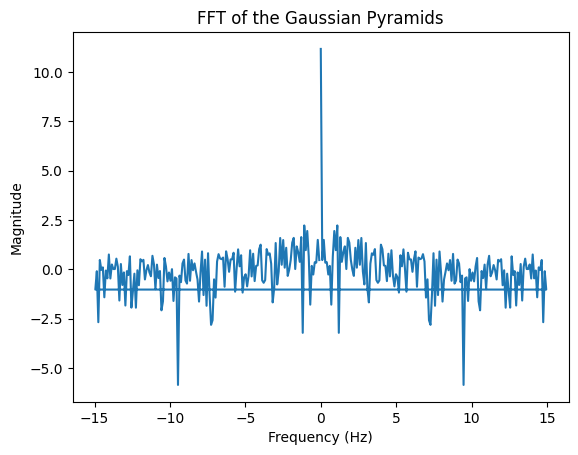

In [12]:
fft = np.fft.fft(gaussian_pyramids,axis=0)
frequencies = np.fft.fftfreq(gaussian_pyramids.shape[0], d=1.0/fps)
# Compute the magnitude of the frequency components
real_part = np.real(fft[:,:,0])
magnitude = np.abs(real_part)
# Take the logarithm of the magnitude to compress the dynamic range
log_magnitude = np.log(magnitude)


# Plot the logarithm of the magnitude
plt.plot(frequencies, log_magnitude[:, 0, 0])

# Add labels to the x- and y-axes
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')

# Add a title to the plot
plt.title('FFT of the Gaussian Pyramids')


[  1.09634551   5.48172757   8.77076412  14.05315615 -12.65780731
  -8.77076412  -5.48172757  -1.09634551]


Text(0.5, 1.0, 'Peaks in the FFT of the Gaussian Pyramids')

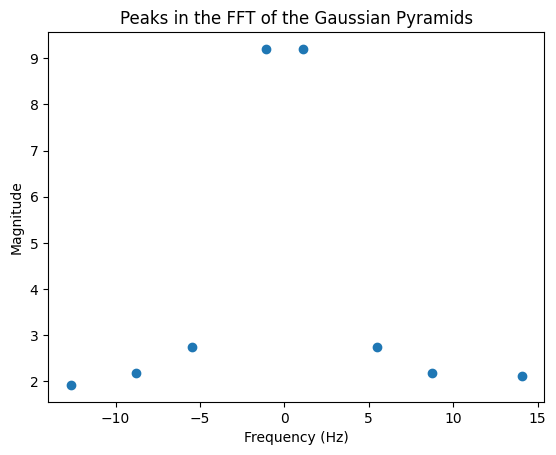

In [13]:
fft = np.fft.fft(gaussian_pyramids,axis=0)
frequencies = np.fft.fftfreq(gaussian_pyramids.shape[0], d=1.0/fps)
# Compute the magnitude of the frequency components
real_part = np.real(fft[:,:,0])
magnitude = np.abs(real_part)

# Use the "find_peaks" function to identify the peaks in the FFT
peaks, _ = find_peaks(magnitude[:, 0, 0], distance=30)
peak_frequencies = frequencies[peaks]
peak_magnitudes = magnitude[peaks]
print(peak_frequencies)
# Plot the frequencies and magnitudes of the peaks
plt.scatter(peak_frequencies, peak_magnitudes[:, 0, 0])

# Add labels to the x- and y-axes
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')

# Add a title to the plot
plt.title('Peaks in the FFT of the Gaussian Pyramids')

0.8970099667774086
53.82059800664451


Text(0.5, 1.0, 'FFT of the Filtered Gaussian Pyramids')

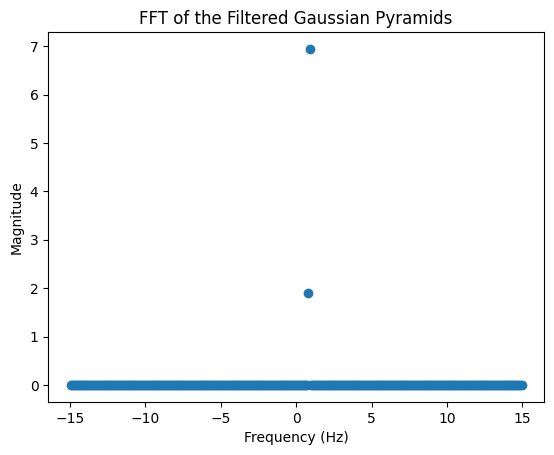

In [15]:
filtered_frequencies = []
fft = np.fft.fft(gaussian_pyramids,axis=0)
frequencies = np.fft.fftfreq(gaussian_pyramids.shape[0], d=1.0/fps)
low = (np.abs(frequencies - freq_range[0])).argmin()
high = (np.abs(frequencies - freq_range[1])).argmin()

fft[:low] = 0
fft[high:] = 0

real_part = np.real(fft[:,:,0])
magnitude = np.abs(real_part)
peak_index = np.argmax(magnitude[:, 0, 0])

peak_frequency = frequencies[peak_index]
print(peak_frequency)
plt.scatter(frequencies, magnitude[:, 0, 0])
for i in range(low, high+1):
    filtered_frequencies.append(frequencies[i])
heart_rates = []
for frequency in filtered_frequencies:
    heart_rate = frequency * 60
    heart_rates.append(heart_rate)
average_heart_rate = np.mean(heart_rates)
print(average_heart_rate)
    
# Add labels to the x- and y-axes
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')

# Add a title to the plot
plt.title('FFT of the Filtered Gaussian Pyramids')


In [ ]:
filtered_pyramids = np.fft.ifft(fft, axis = 0).real
print(filtered_pyramids)